`Install and Import Libraries`

In [1]:
!pip install nltk kagglehub xgboost tensorflow scikit-learn

In [2]:
from joblib import dump
import os
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from time import time
from collections import defaultdict

# ML and NLP imports
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,f1_score
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding,SimpleRNN, GRU, LSTM, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


`Dataset`

In [3]:
# Download dataset from Kaggle
import kagglehub
path = kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")
print("Dataset downloaded to:", path)

# Load data
train_df = pd.read_csv(f"{path}/train.csv", index_col=False)
test_df = pd.read_csv(f"{path}/test.csv", index_col=False)
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Dataset downloaded to: /kaggle/input/ag-news-classification-dataset
Train shape: (120000, 3), Test shape: (7600, 3)


In [4]:
# Combine and prepare data
df = pd.concat([train_df, test_df], axis=0)
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [5]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [6]:
# Text preprocessing function
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens
              if w not in stop_words and w not in string.punctuation]
    return ' '.join(tokens)

In [7]:
# Create combined text and labels
df["text"] = df["title"] + " " + df["description"].fillna("")
df["class_index"] = df["class_index"] - 1
df["label"] = df["class_index"] - 1
df['clean_text'] = df['text'].apply(preprocess_text)
df['label'] = df['label'].astype('category').cat.codes

# Label mapping
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

In [8]:
# Split data (80% train, 10% validation, 10% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42 ,stratify=test_df["label"])

print(f"\nFinal splits: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")


Final splits: Train=102080, Val=12760, Test=12760


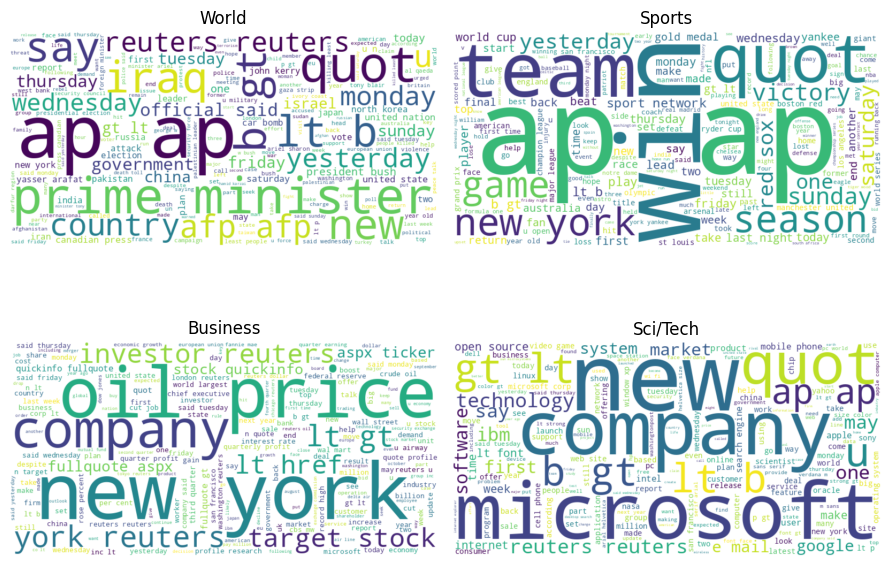

In [19]:
plt.figure(figsize=(9, 7))
for i, (label, name) in enumerate(label_map.items()):
    plt.subplot(2, 2, i+1)
    text = ' '.join(df[df['label'] == label]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(name)
plt.tight_layout()
plt.show()

In [9]:
results = {}

`Model 1: Logistic Regression with TF-IDF `

In [10]:
start = time()
lr_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000)),
    ("clf", LogisticRegression(max_iter=1000))
])
lr_pipeline.fit(train_df['clean_text'], train_df['label'])
train_time = time() - start

preds = lr_pipeline.predict(val_df['clean_text'])
acc = accuracy_score(val_df['label'], preds)
f1 = f1_score(val_df['label'], preds, average='weighted')
results['LogisticRegression'] = {'acc': acc, 'f1': f1, 'model': lr_pipeline, 'type': 'ML'}

print(f"Acc: {acc:.4f} | F1: {f1:.4f} | Time: {train_time:.2f}s")
print(classification_report(val_df['label'], preds, target_names=label_map.values()))


Acc: 0.9156 | F1: 0.9154 | Time: 13.76s
              precision    recall  f1-score   support

       World       0.92      0.90      0.91      3190
      Sports       0.95      0.97      0.96      3190
    Business       0.90      0.89      0.89      3190
    Sci/Tech       0.90      0.89      0.90      3190

    accuracy                           0.92     12760
   macro avg       0.92      0.92      0.92     12760
weighted avg       0.92      0.92      0.92     12760



`Model 2: XGBoost with TF-IDF`

In [11]:
start = time()
xgb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000)),
    ("clf", XGBClassifier(eval_metric='mlogloss', n_estimators=200))
])
xgb_pipeline.fit(train_df['clean_text'], train_df['label'])
train_time = time() - start

preds = xgb_pipeline.predict(val_df['clean_text'])
acc = accuracy_score(val_df['label'], preds)
f1 = f1_score(val_df['label'], preds, average='weighted')
results['XGBoost'] = {'acc': acc, 'f1': f1, 'model': xgb_pipeline, 'type': 'ML'}

print(f"Acc: {acc:.4f} | F1: {f1:.4f} | Time: {train_time:.2f}s")
print(classification_report(val_df['label'], preds, target_names=label_map.values()))

Acc: 0.9103 | F1: 0.9100 | Time: 542.16s
              precision    recall  f1-score   support

       World       0.92      0.91      0.91      3190
      Sports       0.94      0.97      0.95      3190
    Business       0.90      0.88      0.89      3190
    Sci/Tech       0.88      0.89      0.88      3190

    accuracy                           0.91     12760
   macro avg       0.91      0.91      0.91     12760
weighted avg       0.91      0.91      0.91     12760



`Deep Learning Models`

In [12]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['clean_text'])

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['clean_text']), maxlen=200)
X_val_pad = pad_sequences(tokenizer.texts_to_sequences(val_df['clean_text']), maxlen=200)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['clean_text']), maxlen=200)

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

def train_dl_model(name, rnn_layer):
    print("\n" + "="*50)
    print(f"Training {name}")
    print("="*50)

    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=200),
        rnn_layer,
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start = time()
    model.fit(X_train_pad, train_df['label'],
              validation_data=(X_val_pad, val_df['label']),
              epochs=15, batch_size=128, callbacks=[early_stop], verbose=1)
    train_time = time() - start

    preds = np.argmax(model.predict(X_val_pad), axis=1)
    acc = accuracy_score(val_df['label'], preds)
    f1 = f1_score(val_df['label'], preds, average='weighted')

    results[name] = {'acc': acc, 'f1': f1, 'model': model, 'type': 'DL'}

    print(f"Acc: {acc:.4f} | F1: {f1:.4f} | Time: {train_time:.2f}s")
    print(classification_report(val_df['label'], preds, target_names=label_map.values()))


`Model 3: Neural Network with Simple RNN`

In [13]:
train_dl_model("RNN", SimpleRNN(128, return_sequences=True))


Training RNN


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 276s 340ms/step - accuracy: 0.6764 - loss: 0.7664 - val_accuracy: 0.9080 - val_loss: 0.2835
Epoch 2/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 326s 345ms/step - accuracy: 0.9114 - loss: 0.2888 - val_accuracy: 0.9149 - val_loss: 0.2570
Epoch 3/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 316s 338ms/step - accuracy: 0.9273 - loss: 0.2364 - val_accuracy: 0.9142 - val_loss: 0.2598
Epoch 4/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 321s 337ms/step - accuracy: 0.9397 - loss: 0.1892 - val_accuracy: 0.9136 - val_loss: 0.2681
Epoch 5/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 276s 346ms/step - accuracy: 0.9483 - loss: 0.1611 - val_accuracy: 0.9114 - val_loss: 0.2813
399/399 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step
Acc: 0.9149 | F1: 0.9148 | Time: 1560.78s
              precision    recall  f1-score   support

       World       0.93      0.89      0.91      3190
      Sports       0.95      0.98      0.96      3190
    Business       0.88      0.90      0.89      3190
    Sci/Tech       0.89      0.89     

`Model 4: Neural Network with Embedding + GRU`

In [14]:
train_dl_model("GRU", GRU(128, return_sequences=True))


Training GRU


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 754s 940ms/step - accuracy: 0.7574 - loss: 0.6683 - val_accuracy: 0.9153 - val_loss: 0.2574
Epoch 2/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 760s 953ms/step - accuracy: 0.9196 - loss: 0.2566 - val_accuracy: 0.9153 - val_loss: 0.2587
Epoch 3/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 745s 881ms/step - accuracy: 0.9267 - loss: 0.2261 - val_accuracy: 0.9179 - val_loss: 0.2511
Epoch 4/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 712s 892ms/step - accuracy: 0.9336 - loss: 0.1989 - val_accuracy: 0.9179 - val_loss: 0.2548
Epoch 5/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 743s 893ms/step - accuracy: 0.9405 - loss: 0.1714 - val_accuracy: 0.9180 - val_loss: 0.2577
Epoch 6/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 770s 928ms/step - accuracy: 0.9456 - loss: 0.1526 - val_accuracy: 0.9162 - val_loss: 0.2774
399/399 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step
Acc: 0.9179 | F1: 0.9178 | Time: 4485.82s
              precision    recall  f1-score   support

       World       0.94      0.89      0.92      3190
      Sports  

`Model 5: Neural Network with LSTM`

In [15]:
train_dl_model("LSTM", LSTM(128, return_sequences=True))


Training LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 661s 824ms/step - accuracy: 0.7759 - loss: 0.5935 - val_accuracy: 0.9129 - val_loss: 0.2574
Epoch 2/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 671s 842ms/step - accuracy: 0.9187 - loss: 0.2541 - val_accuracy: 0.9168 - val_loss: 0.2479
Epoch 3/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 674s 831ms/step - accuracy: 0.9286 - loss: 0.2223 - val_accuracy: 0.9174 - val_loss: 0.2497
Epoch 4/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 677s 825ms/step - accuracy: 0.9326 - loss: 0.1971 - val_accuracy: 0.9147 - val_loss: 0.2542
Epoch 5/15
798/798 ━━━━━━━━━━━━━━━━━━━━ 691s 866ms/step - accuracy: 0.9398 - loss: 0.1751 - val_accuracy: 0.9148 - val_loss: 0.2588
399/399 ━━━━━━━━━━━━━━━━━━━━ 54s 135ms/step
Acc: 0.9168 | F1: 0.9167 | Time: 3375.19s
              precision    recall  f1-score   support

       World       0.94      0.89      0.92      3190
      Sports       0.95      0.98      0.96      3190
    Business       0.91      0.88      0.89      3190
    Sci/Tech       0.87      0.92    

`Models Comparison`

In [16]:
best_model_name = None
best_score = -1
best_info = None

print("\n" + "="*50)
print("Choosing Best Model Based on Accuracy, F1, and Inference Time")
print("="*50)

for name, info in results.items():
    acc = info['acc']
    f1 = info['f1']


    start_time = time()
    if info['type'] == 'ML':
        _ = info['model'].predict(val_df['clean_text'])
    else:
        _ = np.argmax(info['model'].predict(X_val_pad), axis=1)
    inf_time = time() - start_time

    info['inference_time'] = inf_time

    score = (0.5 * acc) + (0.4 * f1) + (0.1 * (1 / (inf_time + 1e-6)))

    print(f"{name:<20} | Acc: {acc:.4f} | F1: {f1:.4f} | Inf Time: {inf_time:.4f}s | Score: {score:.4f}")

    if score > best_score:
        best_score = score
        best_model_name = name
        best_info = info

print("\n" + "="*50)
print(f"Best Model: {best_model_name}")
print(f"Accuracy: {best_info['acc']:.4f}, F1: {best_info['f1']:.4f}, Inf Time: {best_info['inference_time']:.4f}s")
print("="*50)



Choosing Best Model Based on Accuracy, F1, and Inference Time
LogisticRegression   | Acc: 0.9156 | F1: 0.9154 | Inf Time: 0.4806s | Score: 1.0321
XGBoost              | Acc: 0.9103 | F1: 0.9100 | Inf Time: 1.0234s | Score: 0.9169
399/399 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step
RNN                  | Acc: 0.9149 | F1: 0.9148 | Inf Time: 13.6641s | Score: 0.8307
399/399 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step
GRU                  | Acc: 0.9179 | F1: 0.9178 | Inf Time: 41.0670s | Score: 0.8285
399/399 ━━━━━━━━━━━━━━━━━━━━ 53s 133ms/step
LSTM                 | Acc: 0.9168 | F1: 0.9167 | Inf Time: 81.9829s | Score: 0.8263

Best Model: LogisticRegression
Accuracy: 0.9156, F1: 0.9154, Inf Time: 0.4806s


`Save the best model (Logistic Regression)`

In [17]:
from joblib import dump

# Ensure the pipeline is fitted (this should already be done in your training code)
lr_pipeline.fit(train_df['clean_text'], train_df['label'])

# Save the pipeline with compression (to avoid corruption)
dump(lr_pipeline, "logistic_regression_pipe.joblib", compress=3)  # compress=3 for better reliability
print("✅ Model saved successfully!")

✅ Model saved successfully!
